# PGGAN

This notebook is for implementing __Progressive Growing of GANs for Improved Quality, Stability, and Variation__ from the [paper](https://arxiv.org/pdf/1710.10196.pdf) with [Tensorflow](https://www.tensorflow.org/).  
Datasets are 1024x1024 [celebA-HQ](https://drive.google.com/drive/folders/11Vz0fqHS2rXDb5pprgTjpD7S2BAJhi1P).

Reference: [tkarras's github](https://github.com/tkarras/progressive_growing_of_gans)(official implementation with tensorflow)

## IMPORT MODULE

In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import cv2
import glob
import datetime
from sklearn.utils import shuffle
import time

## DEFINE PARAMETER

In [3]:
algorithm = 'PGGAN'

feature_size = 3
img_size = [4, 8, 16, 32, 64, 128, 256, 512, 1024]
gen_fmaps_size = [512, 512, 512, 512, 256, 128, 64, 32, 16]
dis_fmaps_size = [512, 512, 512, 512, 512, 256, 128, 64, 32, 16, 16]
batch_size = [16, 16, 16, 16, 16, 16, 14, 6, 3]
minibatch_size = [16, 16, 16, 16, 16, 16, 14, 6 ,3]

num_epoch = [27, 54, 54, 54, 54, 54, 54, 54, 54]
num_stage = 9
n_latent = 512

beta1 = 0
beta2 = 0.99
ep = 1e-8

learning_rate = 0.001

train_model = True
load_model = False

date_time = datetime.datetime.now().strftime("%Y%m%d-%H-%M-%S")
save_path = './save_models/' + date_time + "_" + algorithm + "/save"
load_path = './save_models/1024x1024/save'

# WGAN_GP Parateter
D_lambda = 10

## IMPORT DATASET

In [4]:
def img_norm(img):
    return (img - (255/2)) / (255/2)

def denorm(img):
    out = (img + 1) / 2
    return np.clip(out, 0, 1)

In [6]:
def load_img(nums):
    out = []
    for num in nums:
        temp = glob.glob('../../datasets/celebaHQ/data1024x1024/'+str(num).zfill(5)+'.jpg')
        out.append(img_norm(cv2.cvtColor(cv2.imread(temp[0]), cv2.COLOR_BGR2RGB)))      
    return out

## UTILITY

In [9]:
# Utility for batch size image
def batch_resize(img, img_size):
    out = []
    for i in range(len(img)):
        out.append(cv2.resize(img[i], (img_size, img_size)))
    return out

def random_latent(batch_size):
#     return np.random.uniform(-1,1,size=[batch_size, n_latent])
    return np.clip(np.random.normal(0,1,[batch_size,n_latent]),-1,1)

## NETWORK

In [10]:
class PGGAN():
    def __init__(self, stage):
        s = stage
        self.alpha = tf.placeholder(shape=[], dtype=tf.float32, name="alpha_stage{}".format(s))
        self.latent = tf.placeholder(shape=[None, n_latent], dtype=tf.float32, name="latent_stage{}".format(s))
        self.img = tf.placeholder(shape=[None, img_size[s], img_size[s], feature_size], dtype=tf.float32, name="img_stage{}".format(s))
        
        self.fake = self.generator(self.latent, gen_fmaps_size, s)
        
        self.d_real = self.discriminator(self.img, dis_fmaps_size, s)
        self.d_fake = self.discriminator(self.fake, dis_fmaps_size, s)
        
        self.var = [var for var in tf.trainable_variables() if "stage{}".format(s) in var.name]
        self.var_gen = [var for var in self.var if "generator" in var.name]
        self.var_dis = [var for var in self.var if "discriminator" in var.name]
        
        self.loss_g = self.loss_gen(self.d_fake)
        self.loss_d = self.loss_dis(self.img, self.fake, self.d_real, self.d_fake, s)
        
        opt = tf.train.AdamOptimizer(learning_rate=learning_rate, beta1=beta1, beta2=beta2)
        
        self.opt_gen = opt.minimize(self.loss_g, var_list=self.var_gen)
        self.opt_dis = opt.minimize(self.loss_d, var_list=self.var_dis)
        
    def get_weight(self, shape):
        # not just initializing weights but changing weights dynamically
        fan_in = np.prod(shape[:-1])
        w_scale = np.sqrt(2 / fan_in) # He initializer constant
        w = w_scale * tf.get_variable('weight', shape=shape, initializer=tf.initializers.random_normal())
        return w
    
    def apply_bias(self, x):
        b = tf.get_variable('bias', shape=[x.shape[-1]], initializer=tf.initializers.zeros())
        return x + tf.reshape(b, [1,1,1,-1])
        
    def dense(self, x, fmaps):
        w = self.get_weight([x.shape[1].value, fmaps])
        x = tf.matmul(x, w)
        return self.apply_bias(x)
    
    def conv2d(self, x, fmaps, kernel, padding):
        w = self.get_weight([kernel, kernel, x.shape[-1].value, fmaps])
        x = tf.nn.conv2d(x, w, strides=[1,1,1,1], padding=padding)
        return self.apply_bias(x)
    
    def pixel_norm(self, x, epsilon=1e-8):
        # noramlzing weights with axis of feature
        return x / tf.sqrt(tf.reduce_mean(tf.square(x), axis=-1, keepdims=True) + epsilon)
    
    def minibatch(self, x, stage):
        group_size = minibatch_size[stage]
        s = x.shape
        y = tf.reshape(x, [group_size, -1, s[1], s[2], s[3]])
        mean = tf.reduce_mean(y, axis=0, keepdims=True) # mean value of minibatch
        var = tf.reduce_mean(tf.square(y - mean), axis=0) # variance value of minibatch
        std = tf.sqrt(var + 1e-8) # stddev value of minibatch
        y = tf.reduce_mean(std, axis=[1,2,3], keepdims=True) 
        y = tf.tile(y, [group_size, s[1], s[2], 1]) # duplicate value to input size
        return tf.concat([x,y], axis=-1)
    
    def gen_block(self, x, fmaps, scale):
        s = scale
        with tf.variable_scope("scale{}".format(s)):
            with tf.variable_scope("conv1"):
                x = self.conv2d(x, fmaps[s], 3, "SAME")
                x = tf.nn.leaky_relu(x)
                x = self.pixel_norm(x)
            with tf.variable_scope("conv2"):
                x = self.conv2d(x, fmaps[s], 3, "SAME")
                x = tf.nn.leaky_relu(x)
                x = self.pixel_norm(x)
        return x
                
    def dis_block(self, x, fmaps, scale):
        s = scale
        with tf.variable_scope("scale{}".format(s)):
            with tf.variable_scope("conv1"):
                x = self.conv2d(x, fmaps[s+1], 3, "SAME")
                x = tf.nn.leaky_relu(x)
            with tf.variable_scope("conv2"):
                x = self.conv2d(x, fmaps[s], 3, "SAME")
                x = tf.nn.leaky_relu(x)
        return x
    
    def upscale(self, x):
        size = x.shape[1].value * 2
        return tf.image.resize_nearest_neighbor(x, [size,size])
    
    def downscale(self, x):
        return tf.nn.avg_pool2d(x, ksize=2, strides=2, padding="VALID")
    
    def toRGB(self, x, scale, direct):
        s = scale
        # direct 1 is connected with current scale layer and 2 is connected with previous scale layer
        with tf.variable_scope("scale{}".format(s)):
            with tf.variable_scope("toRGB_{}".format(direct)):
                x = self.conv2d(x, feature_size, 1, "SAME")
        return x
        
    def fromRGB(self, x, fmaps, scale, direct):
        s = scale
        # direct 1 is connected with current scale layer and 2 is connected with previous scale layer
        with tf.variable_scope("scale{}".format(s)):
            with tf.variable_scope("fromRGB_{}".format(direct)):
                if direct == 1: x = self.conv2d(x, fmaps[s+1], 1, "SAME")
                else: x = self.conv2d(x, fmaps[s], 1, "SAME")
        return tf.nn.leaky_relu(x)
    
    def generator(self, x, fmaps, stage):
        with tf.variable_scope("generator_stage{}".format(stage), reuse=tf.AUTO_REUSE):
            x = self.pixel_norm(x)

            with tf.variable_scope("scale0"):
                with tf.variable_scope("dense1"): # replace 4x4 deconv layer by using dense layer
                    x = self.dense(x, fmaps[0] * 4**2)
                    x = tf.reshape(x, [-1, 4, 4, fmaps[0]])
                    x = tf.nn.leaky_relu(x)
                    x = self.pixel_norm(x)
                with tf.variable_scope("conv1"):
                    x = self.conv2d(x, fmaps[0], 3, "SAME")
                    x = tf.nn.leaky_relu(x)
                    x = self.pixel_norm(x)
            if stage == 0:
                x = self.toRGB(x, 0, 1)

            # s th scale layers
            for s in range(stage):
                shortcut = x
                up1 = self.upscale(x)
                x = self.gen_block(up1, fmaps, s+1)
                if s == stage-1:
                    rgb1 = self.toRGB(x, s+1, 1)
                    rgb2 = self.toRGB(shortcut, s+1, 2)
                    up2 = self.upscale(rgb2)
                    x = self.alpha*rgb1 + (1-self.alpha)*up2
                    
            return tf.nn.tanh(x)
    
    def discriminator(self, x, fmaps, stage):
        with tf.variable_scope("discriminator_stage{}".format(stage), reuse=tf.AUTO_REUSE):
            rgb1 = self.fromRGB(x, fmaps, stage, 1)
            if stage == 0:
                x = rgb1
            for s in range(stage):
                if s == 0: # the last scale of stage
                    down2 = self.downscale(x)
                    rgb2 = self.fromRGB(down2, fmaps, stage, 2)
                    x = self.dis_block(rgb1, fmaps, stage)
                    down1 = self.downscale(x)
                    x = self.alpha*down1 + (1-self.alpha)*rgb2
                else:
                    x = self.dis_block(x, fmaps, stage-s)
                    up1 = self.downscale(x)
                    x = up1
            
            mini = self.minibatch(x, stage)
    
            with tf.variable_scope("scale0"):
                with tf.variable_scope("conv1"):
                    x = self.conv2d(mini, fmaps[1], 3, "SAME")
                    x = tf.nn.leaky_relu(x)
                with tf.variable_scope("conv2"):
                    x = self.conv2d(x, fmaps[0], 4, "VALID")
                    x = tf.nn.leaky_relu(x)
            
                flat = tf.layers.flatten(x)
                with tf.variable_scope("dense1"):
                    out = self.dense(flat, 1)
                    
        return out
    
    # Use WGAN-GP Loss
    def loss_gen(self, d_fake):
        return -tf.reduce_mean(d_fake)
    
    def loss_dis(self, real, fake, d_real, d_fake, stage):
        loss = tf.reduce_mean(d_fake) - tf.reduce_mean(d_real)
        
        alpha = tf.random_uniform([tf.shape(real)[0],1,1,1], 0, 1)
        mix = alpha*real + (1-alpha)*fake
        d_mix = self.discriminator(mix, dis_fmaps_size, stage)
        loss_mix = tf.reduce_sum(d_mix)
        grad = tf.gradients(loss_mix, [mix])[0]
        norm = tf.sqrt(tf.reduce_sum(tf.square(grad), axis=[1,2,3]))
        GP = tf.square(norm - 1)
        loss += D_lambda*tf.reduce_mean(GP)
        
        loss += 1e-3*tf.reduce_mean(tf.square(d_real)) # preventing dis_loss from diverging
        return loss

## INITIALIZATION

In [ ]:
# Initialize variables
net = [PGGAN(s) for s in range(num_stage)] # train stage step by step, 0 to 8
init = tf.global_variables_initializer()
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
sess = tf.InteractiveSession(config=config)
sess.run(init)

## LOAD MODEL

In [ ]:
Load_Saver = [tf.train.Saver(var_list=net[s].var) for s in range(num_stage)]
Saver = tf.train.Saver()

if load_model == True:
    for s in range(9):
        Load_Saver[s].restore(sess, load_path+str(s))

## TRAIN

In [ ]:
start_time = time.time()
if train_model:
    fixed_latent = random_latent(36)
    len_data = len(input_img)
    for s in range(0,num_stage):
        alpha = 0
        train_set = np.array(range(30000)) + 1
        total_batchs = len_data // batch_size[s]
        
        if s != 0:
            for var in net[s].var_gen:
                var_gen = var.name.split('/')
                for var_old in net[s-1].var_gen:
                    var_gen_old = var_old.name.split('/')
                    
                    if (var_gen[1] == var_gen_old[1]) and (var_gen[2] == var_gen_old[2]) and (var_gen[3] == var_gen_old[3]):
                        sess.run(var.assign(var_old))
                        print(var_gen)
                        print(var_gen_old)
                    if ("RGB_2" in var_gen[2]) and ("RGB_1" in var_gen_old[2]) and (var_gen[3] == var_gen_old[3]):
                        sess.run(var.assign(var_old))
                        print(var_gen)
                        print(var_gen_old)
            print("Generator is assigned!")
            
            for var in net[s].var_dis:
                var_dis = var.name.split('/')
                for var_old in net[s-1].var_dis:
                    var_dis_old = var_old.name.split('/')
                    
                    if (var_dis[1] == var_dis_old[1]) and (var_dis[2] == var_dis_old[2]) and (var_dis[3] == var_dis_old[3]):
                        sess.run(var.assign(var_old))
                        print(var_dis)
                        print(var_dis_old)
                    if ("RGB_2" in var_dis[2]) and ("RGB_1" in var_dis_old[2]) and (var_dis[3] == var_dis_old[3]):
                        sess.run(var.assign(var_old))
                        print(var_dis)
                        print(var_dis_old)
            print("Discriminator is assigned!")
            print("Assignment is Finished!")
                        
        count_batch = 0
        for epoch in range(num_epoch[s]):
            train_set = shuffle(train_set)

            for batch in range(total_batchs):
                batch_set = train_img[batch * batch_size[s] : (batch + 1) * batch_size[s]]
                batch_img = load_img(batch_set)
#                 if stage is 4-64, use batch_resize. Because there is no image dataset for these stages.
#                 if stage is 128-1024, use original image datasets.
#                 batch_img = batch_resize(batch_img, img_size[s])
                batch_latent = random_latent(batch_size[s])
                
                alpha += (1 / (total_batchs*(num_epoch[s]/2)))
                if alpha >= 1: alpha = 1
                
                feed_dict = {net[s].alpha: alpha,
                             net[s].latent: batch_latent,
                             net[s].img: batch_img}
                
                _, loss_dis = sess.run([net[s].opt_dis, net[s].loss_d],
                                       feed_dict = feed_dict)
                
                batch_latent = random_latent(batch_size[s])
                feed_dict = {net[s].alpha: alpha,
                             net[s].latent: batch_latent}
                
                _, loss_gen = sess.run([net[s].opt_gen, net[s].loss_g],
                                              feed_dict = feed_dict)
                second = time.time() - start_time
                print("Stage: {} / Batch: {} / {} / Alpha: {:.3f} / Time: {} d, {} h, {} m, {:.3f} s".format(\
                    s, count_batch, total_batchs*num_epoch[s], alpha,\
                    int(second // (60*60*24)), int(second // (60*60)) % (24), int(second // 60) % 60, second % 60), end="\r")
                    
                count_batch += 1
                
            fake_test = sess.run(net[s].fake, feed_dict = {net[s].latent: fixed_latent,
                                                           net[s].alpha: alpha})
            fig, ax = plt.subplots(6,6, figsize=[5,5])
            for k in range(36):
                ax[k//6,k%6].imshow(denorm(fake_test[k]))
                ax[k//6,k%6].axis("off")
            plt.tight_layout()
            plt.xticks([]), plt.yticks([])
            plt.subplots_adjust(left = 0, bottom = 0, right = 1, top = 1, hspace = 0, wspace = 0)
            fig.savefig("./fixed_latent/" + str(s) + "_" + str(epoch+1).zfill(5) + '.png')
            plt.close(fig)
        Saver.save(sess, save_path+str(s))

## TEST

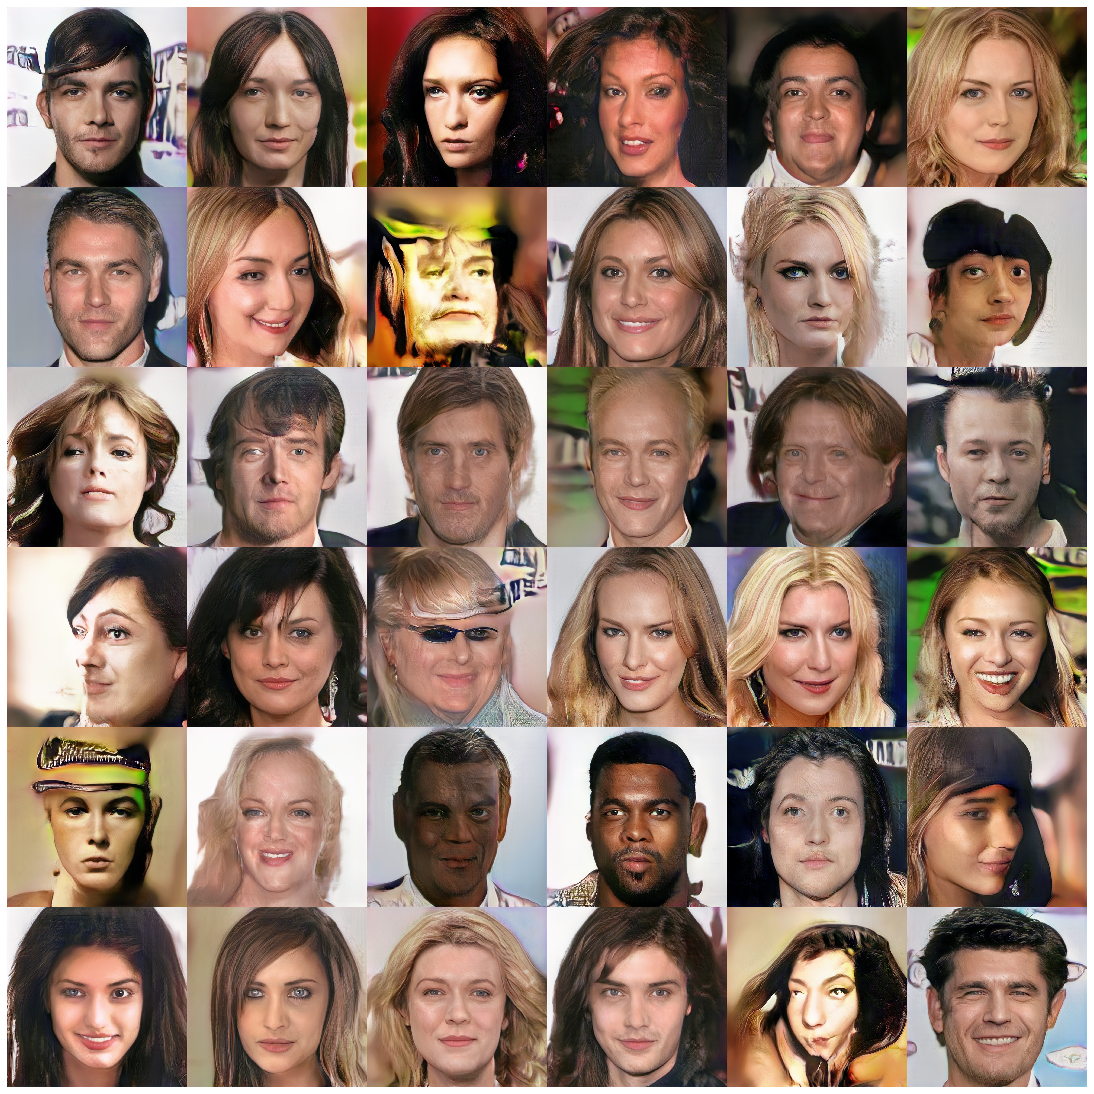

'./savegraph/20200427-12-09-22_PGGAN/save8'

In [14]:
alpha = 1
s = 8
latent_test = random_latent(36)
fake_test = sess.run(net[s].fake, feed_dict = {net[s].latent: latent_test,
                                               net[s].alpha: alpha})
fig, ax = plt.subplots(6,6, figsize=[15,15])
for k in range(36):
    ax[k//6,k%6].imshow(denorm(fake_test[k]))
    ax[k//6,k%6].axis("off")
plt.tight_layout()
plt.xticks([]), plt.yticks([])
plt.subplots_adjust(left = 0, bottom = 0, right = 1, top = 1, hspace = 0, wspace = 0)
plt.show()

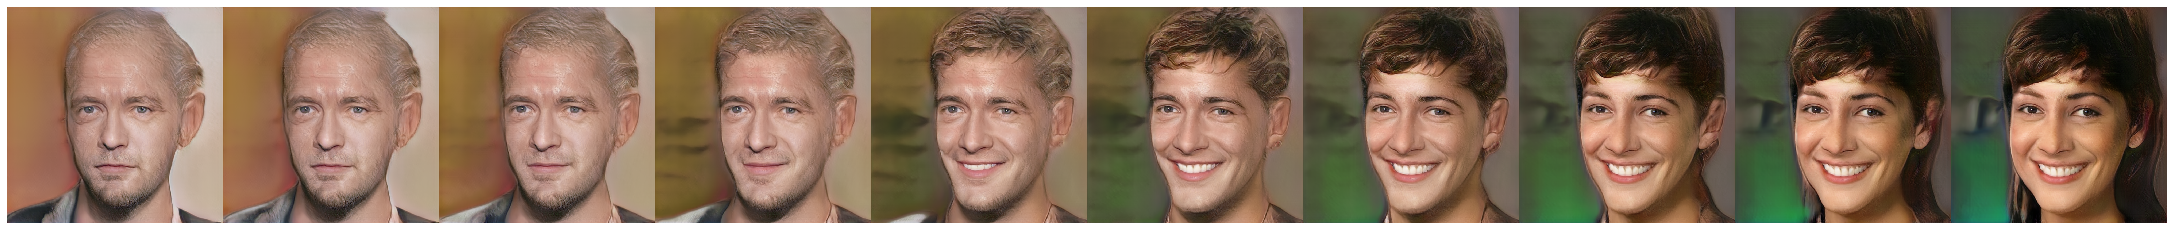

In [105]:
alpha = 1
s = 8
input_a = np.random.uniform(-1,1,[512])
input_b = np.random.uniform(-1,1,[512])
latent_test = np.linspace(input_a, input_b, 10)
fake_test = sess.run(net[s].fake, feed_dict = {net[s].latent: latent_test,
                                               net[s].alpha: alpha})

fig, ax = plt.subplots(1,10, figsize=[15,15])
for k in range(10):
    ax[k].imshow(denorm(fake_test[k]))
    ax[k].axis("off")
plt.tight_layout()
plt.xticks([]), plt.yticks([])
plt.subplots_adjust(left = 0, bottom = 0, right = 1, top = 1, hspace = 0, wspace = 0)
plt.show()